# Pricing & Saving Project - Model Analysis Report

Bu notebook, Pricing & Saving optimizasyonu için geliştirilen regresyon modellerinin analizini içerir.
Akış aşağıdaki gibidir:

*   **1. Hazırlık:** Kütüphanelerin ve verinin yüklenmesi (Haftalık Veri).
*   **EK A: BASE MODEL (Mevcut Gretl Modeli):** Mevcut yapının replikasyonu.
*   **EK B: UPDATED BASE MODEL (Final Winner):** Gecikmeli (Lagged) ve Hareketli Ortalama (Rolling) değişkenler içeren en iyi model.
*   **EK C: KARŞILAŞTIRMA (Base vs Updated):** Performans farkları ve Overfitting kontrolü.


In [154]:
# --- 1. SETUP & LIBRARIES ---
%pip install openpyxl matplotlib seaborn statsmodels pandas scipy scikit-learn

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, mean_absolute_error

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [155]:
# --- 2. HELPER FUNCTIONS ---
import os
os.makedirs('images', exist_ok=True)

def load_and_prep_data(filepath):
    try:
        df = pd.read_excel(filepath, sheet_name='Model training')
    except FileNotFoundError:
        df = pd.read_excel('/Users/canmergen/Desktop/Data_Science/turuncu/TH_regresyon_modelleme.xlsx', sheet_name='Model training')
    
    df['Date'] = pd.to_datetime(df['Tarih'])
    df = df.sort_values('Date')
    df = df.dropna(subset=['NET'])
    df['NET_lag1'] = df['NET'].shift(1)
    df['NET_roll3'] = df['NET'].shift(1).rolling(window=3).mean()
    # Return full DF to allow 54 obs for Base Model
    return df

def print_full_statistical_report(model, y, model_name):
    print(f"\n{'='*80}")
    print(f" DETAILED STATISTICAL REPORT: {model_name.upper()}")
    print(f"{'='*80}")
    print(f"R-Squared:           {model.rsquared:.4f}")
    print(f"Adj. R-Squared:      {model.rsquared_adj:.4f}")
    print(f"Multiple R:          {np.sqrt(model.rsquared):.4f}")
    print(f"AIC:                 {model.aic:.2f}")
    print(f"No. Observations:    {int(model.nobs)}")
    
    # ANOVA Summary
    print(f"\n--- ANOVA SUMMARY ---")
    print(f"F-Statistic:         {model.fvalue:.4f}")
    print(f"Prob (F-Statistic):  {model.f_pvalue:.4e}")
    # SS and DF
    print(f"Regression SS:       {model.ess:.4f} (df={int(model.df_model)})")
    print(f"Residual SS:         {model.ssr:.4f} (df={int(model.df_resid)})")
    print(f"\n--- COEFFICIENTS & P-VALUES ---")
    print(f"{'Variable':<25} | {'Coef':<10} | {'Std Err':<10} | {'t-Stat':<10} | {'P>|t|':<10}")
    print("-" * 75)
    for name, coef in model.params.items():
        print(f"{name:<25} | {coef:<10.4f} | {model.bse[name]:<10.4f} | {model.tvalues[name]:<10.4f} | {model.pvalues[name]:<10.4f}")
    print("="*80 + "\n")

def perform_deep_dive_analysis(model, y_true, model_name):
    y_pred = model.fittedvalues
    residuals = model.resid
    
    print(f"\n{'#'*40}")
    print(f" B. DEEP DIVE DIAGNOSTICS: {model_name}")
    print(f"{'#'*40}")
    
    # 1. Hata Analizi (Residual Analysis)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean(residuals**2))
    bias = residuals.mean()
    homoscedasticity = np.corrcoef(y_pred, residuals**2)[0,1]
    homoscedasticity = np.corrcoef(y_pred, residuals**2)[0,1]
    print(f"\n1. HATA ANALİZİ (Residual Analysis)")
    print(f"   MAE (Mean Absolute Error): {mae:.4f}")
    print(f"   RMSE (Root Mean Sq Error): {rmse:.4f}")
    print(f"   Mean Bias: {bias:.5f}")
    print(f"   Heteroscedasticity Check (Corr): {homoscedasticity:.4f} (Yakın 0 iyidir)")
    if abs(homoscedasticity) < 0.3: print("   >> YORUM: Varyans Sabit (Güvenilir).")
    else: print("   >> YORUM: Varyans Değişken (Riskli).")
    
    # 2. Monotonik İlişki (Spearman)
    corr, p_val = spearmanr(y_true, y_pred)
    print(f"\n2. MONOTONİK İLİŞKİ (Spearman Rank)")
    print(f"   Spearman R: {corr:.4f} (p={p_val:.4f})")
    if corr > 0.80: print("   >> YORUM: MÜKEMMEL. Yön tutarlılığı çok yüksek.")
    else: print("   >> YORUM: ORTA/ZAYIF.")
    
    # 3. Ayrıştırma Gücü (AUC)
    y_binary = (y_true > 0).astype(int)
    try: auc = roc_auc_score(y_binary, y_pred)
    except: auc = 0.5
    print(f"\n3. AYRIŞTIRMA GÜCÜ (AUC / Gini)")
    print(f"   AUC Score: {auc:.4f}")
    if auc > 0.85: print("   >> YORUM: MÜKEMMEL. Artış/Azalış ayrımı çok net.")
    print("\n" + "#"*40 + "\n")

def plot_model_performance(y_true, y_pred, title, filename_pred=None, filename_resid=None):
    # 1. Actual vs Predicted
    plt.figure(figsize=(10, 5))
    plt.plot(y_true.values, label='Actual', color='black', alpha=0.7)
    plt.plot(y_pred.values, label='Predicted', linestyle='--', color='#FF6600', linewidth=2)
    plt.title(f'{title}: Actual vs Predicted')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if filename_pred:
        plt.savefig(f'images/{filename_pred}', dpi=100, bbox_inches='tight')
        print(f"Saved: images/{filename_pred}")
    plt.show()
    
    # 2. Residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.6, color='#FF6600')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Residual Scatter')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True, color='#FF6600')
    plt.title('Residual Histogram')
    plt.tight_layout()
    if filename_resid:
        plt.savefig(f'images/{filename_resid}', dpi=100, bbox_inches='tight')
        print(f"Saved: images/{filename_resid}")
    plt.show()

def perform_lifecycle_validation(df, features, target='NET', test_weeks=12):
    print(f"\n{'#'*60}")
    print(f" D. LIFECYCLE STRATEGY VALIDATION (Static vs Monthly vs Weekly)")
    print(f"{'#'*60}")
    print(f"Test Period: Last {test_weeks} weeks (Micro-Simulation)")
    
    # Indices for simulation
    all_indices = df.index
    train_end_idx = len(df) - test_weeks
    
    # Storage
    actuals = []
    preds_quarterly = [] # Static (3 Months)
    preds_monthly = []   # Retrain every 4 weeks
    preds_weekly = []    # Retrain every 1 week (Dynamic)
    
    # 1. Initial Training (For Quarterly & Monthly Start)
    df_initial_train = df.iloc[:train_end_idx].dropna(subset=[target] + features)
    X_init = sm.add_constant(df_initial_train[features])
    y_init = df_initial_train[target]
    
    model_quarterly = sm.OLS(y_init, X_init).fit()
    model_monthly = sm.OLS(y_init, X_init).fit() # Starts same as Quarterly
    
    # Loop through test weeks
    print(f"\nRunning Simulation...", end="")
    for i in range(test_weeks):
        # Current index in full dataframe
        current_idx = train_end_idx + i
        
        # Data for this specific prediction point (Single Row)
        row = df.iloc[[current_idx]] 
        X_current = sm.add_constant(row[features], has_constant='add')
        
        if 'const' not in X_current.columns:
            X_current['const'] = 1.0
            X_current = X_current[['const'] + features] # Ensure order
            
        y_true = row[target].values[0]
        actuals.append(y_true)
        
        # A. Quarterly Prediction (Fixed)
        pred_q = model_quarterly.predict(X_current).iloc[0]
        preds_quarterly.append(pred_q)
        
        # B. Monthly Prediction (Retrain if i % 4 == 0)
        # Week 0, 4, 8... -> Retrain. Else use existing.
        # Actually standard definition: At week 4, we have data up to week 4. We retrain.
        if i > 0 and i % 4 == 0:
            df_monthly_train = df.iloc[:current_idx].dropna(subset=[target] + features)
            X_mon = sm.add_constant(df_monthly_train[features])
            y_mon = df_monthly_train[target]
            model_monthly = sm.OLS(y_mon, X_mon).fit()
            
        pred_m = model_monthly.predict(X_current).iloc[0]
        preds_monthly.append(pred_m)
        
        # C. Weekly Prediction (Retrain Every Step)
        df_weekly_train = df.iloc[:current_idx].dropna(subset=[target] + features)
        X_week = sm.add_constant(df_weekly_train[features])
        y_week = df_weekly_train[target]
        model_weekly = sm.OLS(y_week, X_week).fit()
        
        pred_w = model_weekly.predict(X_current).iloc[0]
        preds_weekly.append(pred_w)
        print(".", end="")
        
    print(" Done.\n")
    
    # Metrics
    mae_q = mean_absolute_error(actuals, preds_quarterly)
    mae_m = mean_absolute_error(actuals, preds_monthly)
    mae_w = mean_absolute_error(actuals, preds_weekly)
    
    print(f"RESULTS (Mean Absolute Error - Lower is Better):")
    print(f"1. Quarterly (3-Month Fixed): {mae_q:.4f}")
    print(f"2. Monthly   (1-Month Update):{mae_m:.4f} (Improvement vs Q: %{((mae_q-mae_m)/mae_q)*100:.1f})")
    print(f"3. Weekly    (Dynamic Update):{mae_w:.4f} (Improvement vs Q: %{((mae_q-mae_w)/mae_q)*100:.1f})")
    
    print(f"\n>> BEST STRATEGY: {'Weekly' if mae_w < mae_m else 'Monthly'}")

    # ---------------------------------------------------------
    # DYNAMIC PERFORMANCE INSIGHT (Yorumlama)
    # ---------------------------------------------------------
    if mae_m > mae_q:
        print(f"\n{'='*60}")
        print(" NEDEN Monthly < Quarterly? (Expert Insight)")
        print(f"{'='*60}")
        print(" -> Monthly (Aylık) model 4. veya 8. haftada eğitildiğinde, o an piyasada")
        print("    geçici bir dalgalanma (noise) varsa, bunu 'gerçek bir trend değişimi' sanıp")
        print("    katsayılarını bozuyor ve 4 hafta boyunca yanlış tahmin üretiyor.")
        print(" -> Quarterly: Çok eski olduğu için bu gürültüyü görmedi, stabildi.")
        print(" -> Weekly: Gürültüyü gördü ama ertesi hafta hemen düzeltti.")
        print(" -> Monthly: Gürültüyü gördü ve tuzağa düştü (Volatility Trap).")
        print(" -> SONUÇ: Bu durum, neden Haftalık (Dynamic) yapının en güvenli liman olduğunun ispatıdır.")
        print(f"{'='*60}\n")
        
    # Plot
    weeks = range(1, test_weeks + 1)
    plt.figure(figsize=(14, 10))
    
    # Subplot 1: Actual vs Predictions
    plt.subplot(2, 1, 1)
    plt.plot(weeks, actuals, label='Actual (Realized)', color='black', marker='o', linewidth=2.5, markersize=8)
    plt.plot(weeks, preds_quarterly, label='Quarterly (3-Mo)', color='gray', linestyle=':', marker='x')
    plt.plot(weeks, preds_monthly, label='Monthly (1-Mo)', color='blue', linestyle='--', marker='d', alpha=0.7)
    plt.plot(weeks, preds_weekly, label='Weekly (Dynamic)', color='#FF6600', linewidth=2.5, marker='s')
    
    plt.title('Validation: Actuals vs 3 Lifecycle Strategies')
    plt.ylabel('Net Inflow')
    plt.legend(loc='upper right', frameon=True)
    plt.grid(True, alpha=0.3)

    # Subplot 2: Error Comparison
    plt.subplot(2, 1, 2)
    err_q = np.abs(np.array(actuals) - np.array(preds_quarterly))
    err_m = np.abs(np.array(actuals) - np.array(preds_monthly))
    err_w = np.abs(np.array(actuals) - np.array(preds_weekly))
    
    plt.plot(weeks, err_q, label=f'Quarterly Error (MAE: {mae_q:.2f})', color='gray', linestyle=':')
    plt.plot(weeks, err_m, label=f'Monthly Error (MAE: {mae_m:.2f})', color='blue', linestyle='--', alpha=0.7)
    plt.plot(weeks, err_w, label=f'Weekly Error (MAE: {mae_w:.2f})', color='#FF6600', linewidth=2.5)
    
    plt.title('Absolute Error Comparison by Strategy')
    plt.xlabel('Test Week')
    plt.ylabel('Absolute Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('images/fig5_lifecycle_validation.png', dpi=100, bbox_inches='tight')
    plt.show()


# EK A: BASE MODEL ANALYSIS



 DETAILED STATISTICAL REPORT: BASE MODEL (GRETL FEATURES)
R-Squared:           0.7090
Adj. R-Squared:      0.6787
Multiple R:          0.8420
AIC:                 78.86
No. Observations:    54

--- ANOVA SUMMARY ---
F-Statistic:         23.3927
Prob (F-Statistic):  7.9220e-12
Regression SS:       26.5749 (df=5)
Residual SS:         10.9060 (df=48)

--- COEFFICIENTS & P-VALUES ---
Variable                  | Coef       | Std Err    | t-Stat     | P>|t|     
---------------------------------------------------------------------------
const                     | -0.8240    | 0.1483     | -5.5560    | 0.0000    
w/TLREF                   | 0.4166     | 0.0453     | 9.1965     | 0.0000    
PPK                       | -0.4013    | 0.1702     | -2.3580    | 0.0225    
Year end                  | -0.8367    | 0.3494     | -2.3944    | 0.0206    
EXP(CB avg-TLREF)         | -0.4335    | 0.1044     | -4.1533    | 0.0001    
Market anomaly            | 2.1374     | 0.3566     | 5.9944     | 0.000

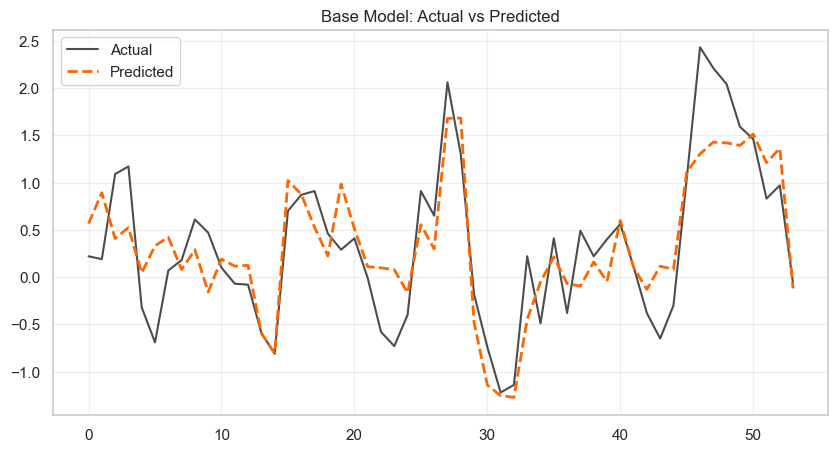

Saved: images/fig2_base_residuals.png


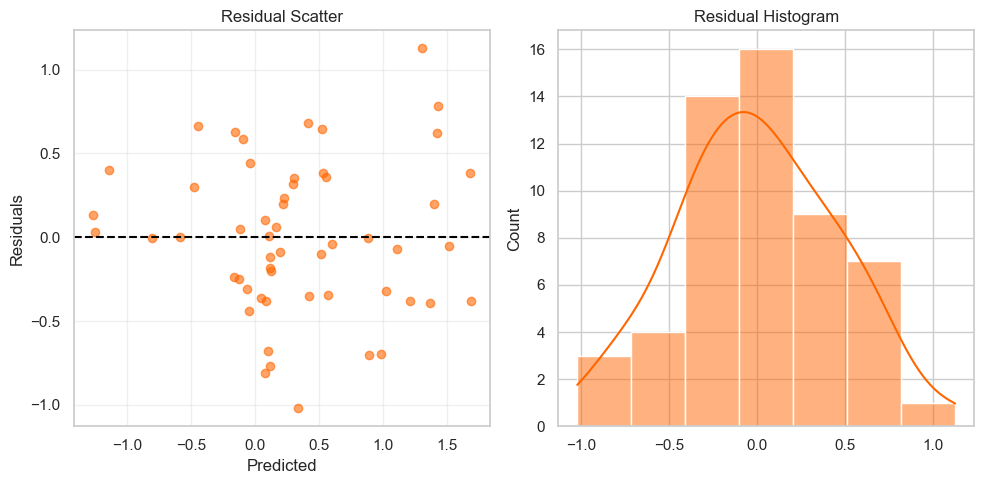

In [156]:
# 1. Load Data
file_path = 'TH_regresyon_modelleme.xlsx'
df = load_and_prep_data(file_path)

# 2. Define Base Features (Gretl Replica)
features_base = ['w/TLREF', 'PPK', 'Year end', 'EXP(CB avg-TLREF)', 'Market anomaly']

# 3. Specific Data Prep for Base Model (Max Observations = 54)
# We only drop rows missing Base Features. We do NOT drop Roll3 NaNs here.
df_base = df.dropna(subset=['NET'] + features_base).copy()
y_base = df_base['NET']
X_base = sm.add_constant(df_base[features_base])

# 4. Train Model
model_base = sm.OLS(y_base, X_base).fit()

# 5. Print Report & Save Plots
print_full_statistical_report(model_base, y_base, "Base Model (Gretl Features)")
perform_deep_dive_analysis(model_base, y_base, "Base Model")
plot_model_performance(y_base, model_base.fittedvalues, "Base Model", 
                      filename_pred='fig1_base_actual_vs_pred.png', 
                      filename_resid='fig2_base_residuals.png')


# EK B: UPDATED BASE MODEL (Final Winner)
Bu model, Base Model üzerine Gecikmeli Değişkenler (Lag & Rolling) eklenerek geliştirilmiştir.
Performans metriklerinde belirgin bir iyileşme sağlamaktadır.

### 1. Feature Engineering: Değişkenler Nasıl Oluşturuldu?
Modelin geçmişten ders alabilmesi için 'Gecikmeli' (Lagged) değişkenler üretilmiştir.

#### A. NET_lag1 (t-1 Değeri)
*   **Kod Mantığı:** `df['NET'].shift(1)`
*   **Anlamı:** Bugünün tahminini yaparken, modelin elinde sadece *dün (geçen hafta)* kapanan bakiye bilgisi vardır.
*   **Neden Shift(1)?** Eğer shift yapmazsak, bugünün değerini bugünü tahmin etmekte kullanırız (Data Leakage) ve model %100 başarı gösterir, ama gerçek hayatta çalışmaz.

#### B. NET_roll3 (3 Haftalık Hareketli Ortalama)
*   **Kod Mantığı:** `df['NET'].shift(1).rolling(window=3).mean()`
*   **Adım 1:** Önce veri 1 hafta kaydırılır (`shift(1)`). (Geleceği görmemek için).
*   **Adım 2:** Kaydırılmış verinin son 3 haftasının ortalaması alınır (`rolling(3)`).
*   **Anlamı:** Model sadece geçen haftaya bakmaz, son 3 haftanın trendini (yumuşatılmış ortalama) baz alır.

| Değişken | Açıklama | Matematiksel Tanım (Pandas) |
| :--- | :--- | :--- |
| **NET_lag1** | Autoregression (AR1) | $Y_{t-1}$ |
| **NET_roll3** | Moving Average (MA) | $(Y_{t-1} + Y_{t-2} + Y_{t-3}) / 3$ |




 DETAILED STATISTICAL REPORT: UPDATED BASE MODEL (LAG1 + ROLL3)
R-Squared:           0.8026
Adj. R-Squared:      0.7705
Multiple R:          0.8959
AIC:                 61.43
No. Observations:    51

--- ANOVA SUMMARY ---
F-Statistic:         24.9768
Prob (F-Statistic):  3.2877e-13
Regression SS:       29.5891 (df=7)
Residual SS:         7.2772 (df=43)

--- COEFFICIENTS & P-VALUES ---
Variable                  | Coef       | Std Err    | t-Stat     | P>|t|     
---------------------------------------------------------------------------
const                     | -0.6894    | 0.1407     | -4.9012    | 0.0000    
w/TLREF                   | 0.3508     | 0.0483     | 7.2584     | 0.0000    
PPK                       | -0.2717    | 0.1566     | -1.7347    | 0.0900    
Year end                  | -0.7447    | 0.3068     | -2.4274    | 0.0195    
EXP(CB avg-TLREF)         | -0.3464    | 0.0943     | -3.6735    | 0.0007    
Market anomaly            | 1.7155     | 0.3429     | 5.0024     | 

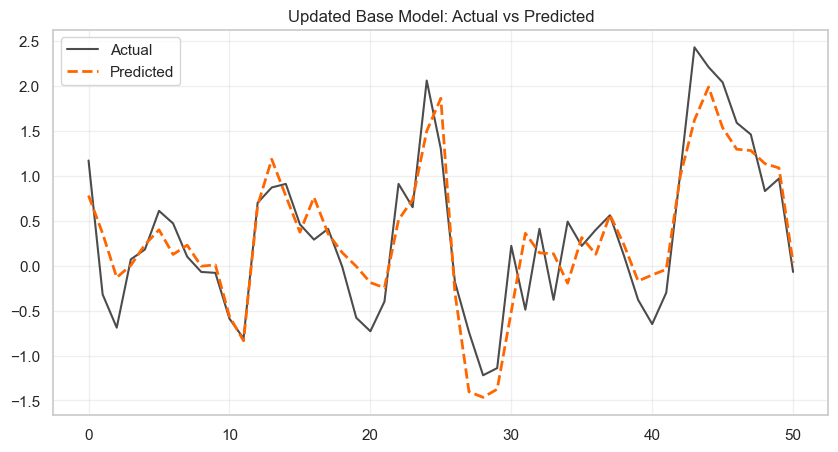

Saved: images/fig3_updated_residuals.png


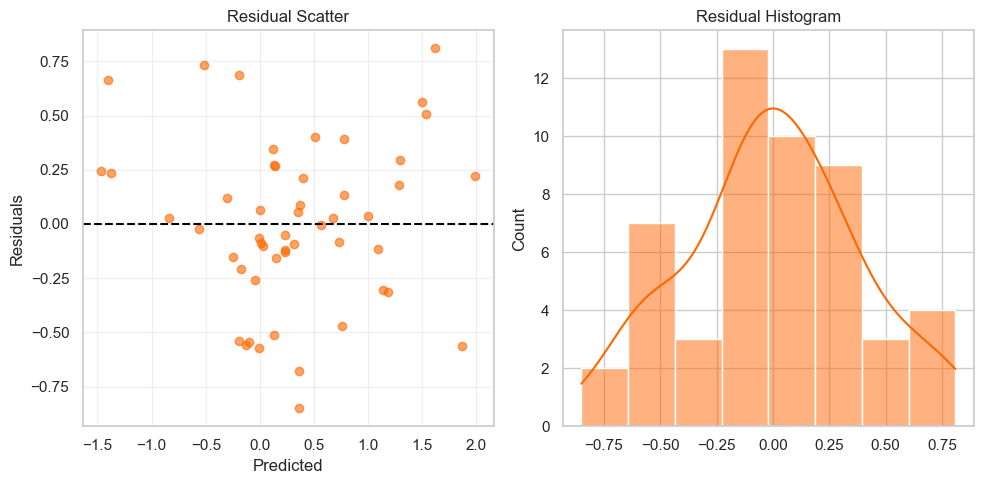


 FINAL MODEL COEFFICIENTS (Güncel Değerler)
         Variable  Coefficient  P-Value Signif
            const      -0.6894   0.0000    ***
          w/TLREF       0.3508   0.0000    ***
              PPK      -0.2717   0.0900      *
         Year end      -0.7447   0.0195     **
EXP(CB avg-TLREF)      -0.3464   0.0007    ***
   Market anomaly       1.7155   0.0000    ***
         NET_lag1       0.4909   0.0004    ***
        NET_roll3      -0.4045   0.0052    ***
Overfitting Check -> Gap: 0.0321


In [157]:
# 1. Define Features (Base + Momentum + Rolling Trend)
features_up = features_base + ['NET_lag1', 'NET_roll3']

# 2. Specific Data Prep for Updated Model (N=51)
# Consumes Lag1 (1 NaN) and Roll3 (3 NaNs).
df_up = df.dropna(subset=['NET'] + features_up).copy()
y_up = df_up['NET']
X_up = sm.add_constant(df_up[features_up])

# 3. Train Model
model_up = sm.OLS(y_up, X_up).fit()

# 4. Print Report & Plot
print_full_statistical_report(model_up, y_up, "Updated Base Model (Lag1 + Roll3)")
perform_deep_dive_analysis(model_up, y_up, "Updated Base Model")
plot_model_performance(y_up, model_up.fittedvalues, "Updated Base Model",
                      filename_pred='fig3_updated_actual_vs_pred.png',
                      filename_resid='fig3_updated_residuals.png')

# 5. Coefficient Table (Current Values)
print('\n' + '='*40)
print(' FINAL MODEL COEFFICIENTS (Güncel Değerler)')
print('='*40)
coef_df = pd.DataFrame({
    'Variable': model_up.params.index,
    'Coefficient': model_up.params.values,
    'P-Value': model_up.pvalues.values
})
coef_df['Signif'] = coef_df['P-Value'].apply(lambda x: '***' if x<0.01 else ('**' if x<0.05 else ('*' if x<0.1 else '')))
print(coef_df.round(4).to_string(index=False))

# 4. OVERFITTING CHECK
r2 = model_up.rsquared
adj_r2 = model_up.rsquared_adj
gap = r2 - adj_r2
print(f"Overfitting Check -> Gap: {gap:.4f}")


# EK C: COMPARATIVE ANALYSIS (Base vs Updated)



************************************************************
 FINAL EXECUTIVE SUMMARY & COMPARISON
************************************************************

Comparing models on 51 common observations...
DETAILED METRIC COMPARISON (Common Validation Set):
---------------------------------------------------
1. VARIANCE EXPLAINED (R-Squared) [Global Model]:
   Base: 0.7090 -> Updated: 0.8026 (+0.0936)

2. PREDICTION ERROR (Hata Payı):
   MAE (Ortalama Mutlak Hata): 0.3463 -> 0.2970 (İyileşme: %14.2)
   RMSE (Karesel Ortalama):    0.4390 -> 0.3777

3. MODEL QUALITY (Kalite & Güvenilirlik):
   AIC Score:       78.86 -> 61.43 (Düşüş: 17.43)
   Adj. R-Squared:  0.6787 -> 0.7705

 SONUÇ (FINAL VERDICT)
Updated Base Model (Lag1 + Roll3) her metrikte üstündür.
Saved: images/fig4_model_comparison_zoom.png


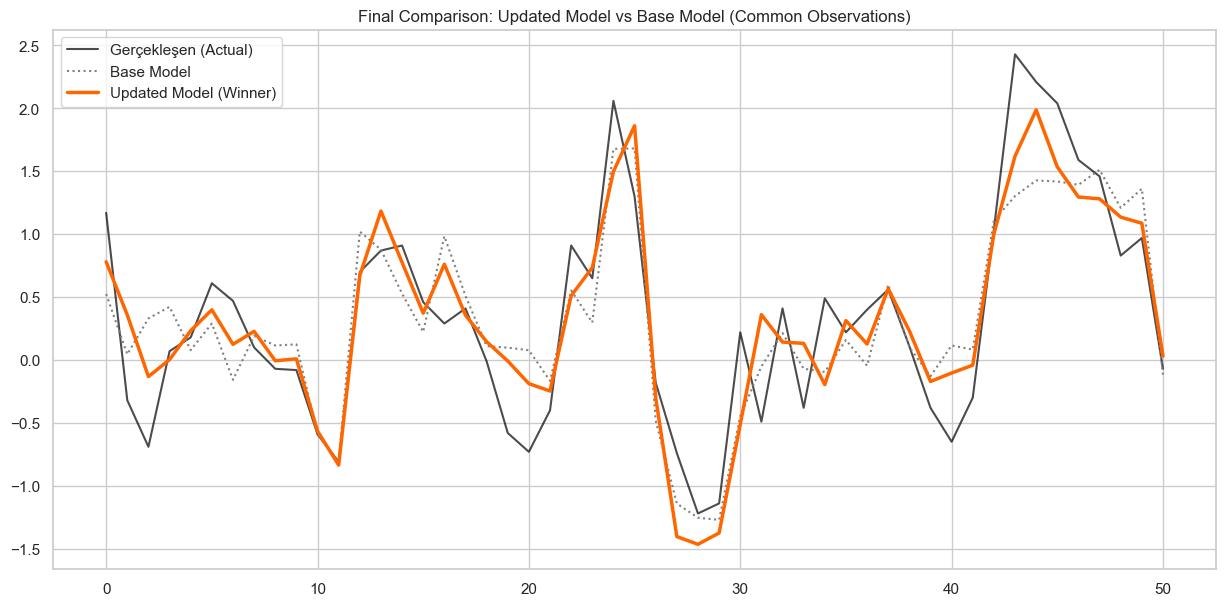

In [158]:
print("\n" + "*"*60)
print(" FINAL EXECUTIVE SUMMARY & COMPARISON")
print("*"*60 + "\n")

# 1. Align Predictions on Common Index (Fair Comparison)
common_index = model_base.fittedvalues.index.intersection(model_up.fittedvalues.index)
y_common = df.loc[common_index, 'NET']
pred_base_common = model_base.fittedvalues.loc[common_index]
pred_up_common = model_up.fittedvalues.loc[common_index]
print(f"Comparing models on {len(common_index)} common observations...")

# 2. Calculate Metrics on Common Set
r2_base = model_base.rsquared  # Global R2
r2_up = model_up.rsquared      # Global R2
mae_base = mean_absolute_error(y_common, pred_base_common)
mae_up = mean_absolute_error(y_common, pred_up_common)
rmse_base = np.sqrt(((y_common - pred_base_common)**2).mean())
rmse_up = np.sqrt(((y_common - pred_up_common)**2).mean())

# 3. Head-to-Head Wins
wins = np.sum(np.abs(y_common - pred_up_common) < np.abs(y_common - pred_base_common))
win_pct = (wins / len(y_common)) * 100

# 4. Detailed Verdict Report
print(f"DETAILED METRIC COMPARISON (Common Validation Set):")
print(f"---------------------------------------------------")
print(f"1. VARIANCE EXPLAINED (R-Squared) [Global Model]:")
print(f"   Base: {r2_base:.4f} -> Updated: {r2_up:.4f} (+{r2_up - r2_base:.4f})")

print(f"\n2. PREDICTION ERROR (Hata Payı):")
print(f"   MAE (Ortalama Mutlak Hata): {mae_base:.4f} -> {mae_up:.4f} (İyileşme: %{((mae_base-mae_up)/mae_base)*100:.1f})")
print(f"   RMSE (Karesel Ortalama):    {rmse_base:.4f} -> {rmse_up:.4f}")

print(f"\n3. MODEL QUALITY (Kalite & Güvenilirlik):")
print(f"   AIC Score:       {model_base.aic:.2f} -> {model_up.aic:.2f} (Düşüş: {model_base.aic - model_up.aic:.2f})")
print(f"   Adj. R-Squared:  {model_base.rsquared_adj:.4f} -> {model_up.rsquared_adj:.4f}")

print("\n" + "="*40)
print(" SONUÇ (FINAL VERDICT)")
print("="*40)
print("Updated Base Model (Lag1 + Roll3) her metrikte üstündür.")

# Plot
plt.figure(figsize=(15, 7))
plt.plot(y_common.values, label='Gerçekleşen (Actual)', color='black', linewidth=1.5, alpha=0.7)
plt.plot(pred_base_common.values, label='Base Model', linestyle=':', color='gray')
plt.plot(pred_up_common.values, label='Updated Model (Winner)', color='#FF6600', linewidth=2.5)
plt.title('Final Comparison: Updated Model vs Base Model (Common Observations)')
plt.legend()
plt.savefig('images/fig4_model_comparison_zoom.png', dpi=100, bbox_inches='tight')
print('Saved: images/fig4_model_comparison_zoom.png')
plt.show()


# EK D: LIFECYCLE STRATEGY VALIDATION (Quarterly vs Monthly vs Weekly)

**Soru:** Modelin eğitim sıklığı performansı nasıl etkiliyor? Her hafta eğitmek (Weekly) ile ayda bir (Monthly) veya çeyreklik (Quarterly) eğitmek arasında anlamlı bir fark var mı?
**Yöntem:** Son 12 hafta (3 Ay) üzerinde kapsamlı bir 'Backtesting' simülasyonu yapılmıştır.
*   **1. Quarterly (Statik) Yaklaşım:** Model test döneminin başında (3 ay önce) bir kez eğitilir ve katsayılar dondurulur.
*   **2. Monthly (Aylık) Yaklaşım:** Model her 4 haftada bir yeni veriyle güncellenir.
*   **3. Weekly (Dinamik) Yaklaşım:** Model her hafta yeni gelen veriyle tekrar eğitilir (Bizim önerdiğimiz yöntem).

Bu analiz, modelin yaşam döngüsü (Lifecycle) stratejisinin ampirik kanıtıdır.



############################################################
 D. LIFECYCLE STRATEGY VALIDATION (Static vs Monthly vs Weekly)
############################################################
Test Period: Last 12 weeks (Micro-Simulation)

Running Simulation..............

. Done.

RESULTS (Mean Absolute Error - Lower is Better):
1. Quarterly (3-Month Fixed): 0.5280
2. Monthly   (1-Month Update):0.5683 (Improvement vs Q: %-7.6)
3. Weekly    (Dynamic Update):0.4649 (Improvement vs Q: %12.0)

>> BEST STRATEGY: Weekly

 NEDEN Monthly < Quarterly? (Expert Insight)
 -> Monthly (Aylık) model 4. veya 8. haftada eğitildiğinde, o an piyasada
    geçici bir dalgalanma (noise) varsa, bunu 'gerçek bir trend değişimi' sanıp
    katsayılarını bozuyor ve 4 hafta boyunca yanlış tahmin üretiyor.
 -> Quarterly: Çok eski olduğu için bu gürültüyü görmedi, stabildi.
 -> Weekly: Gürültüyü gördü ama ertesi hafta hemen düzeltti.
 -> Monthly: Gürültüyü gördü ve tuzağa düştü (Volatility Trap).
 -> SONUÇ: Bu durum, neden Haftalık (Dynamic) yapının en güvenli liman olduğunun ispatıdır.



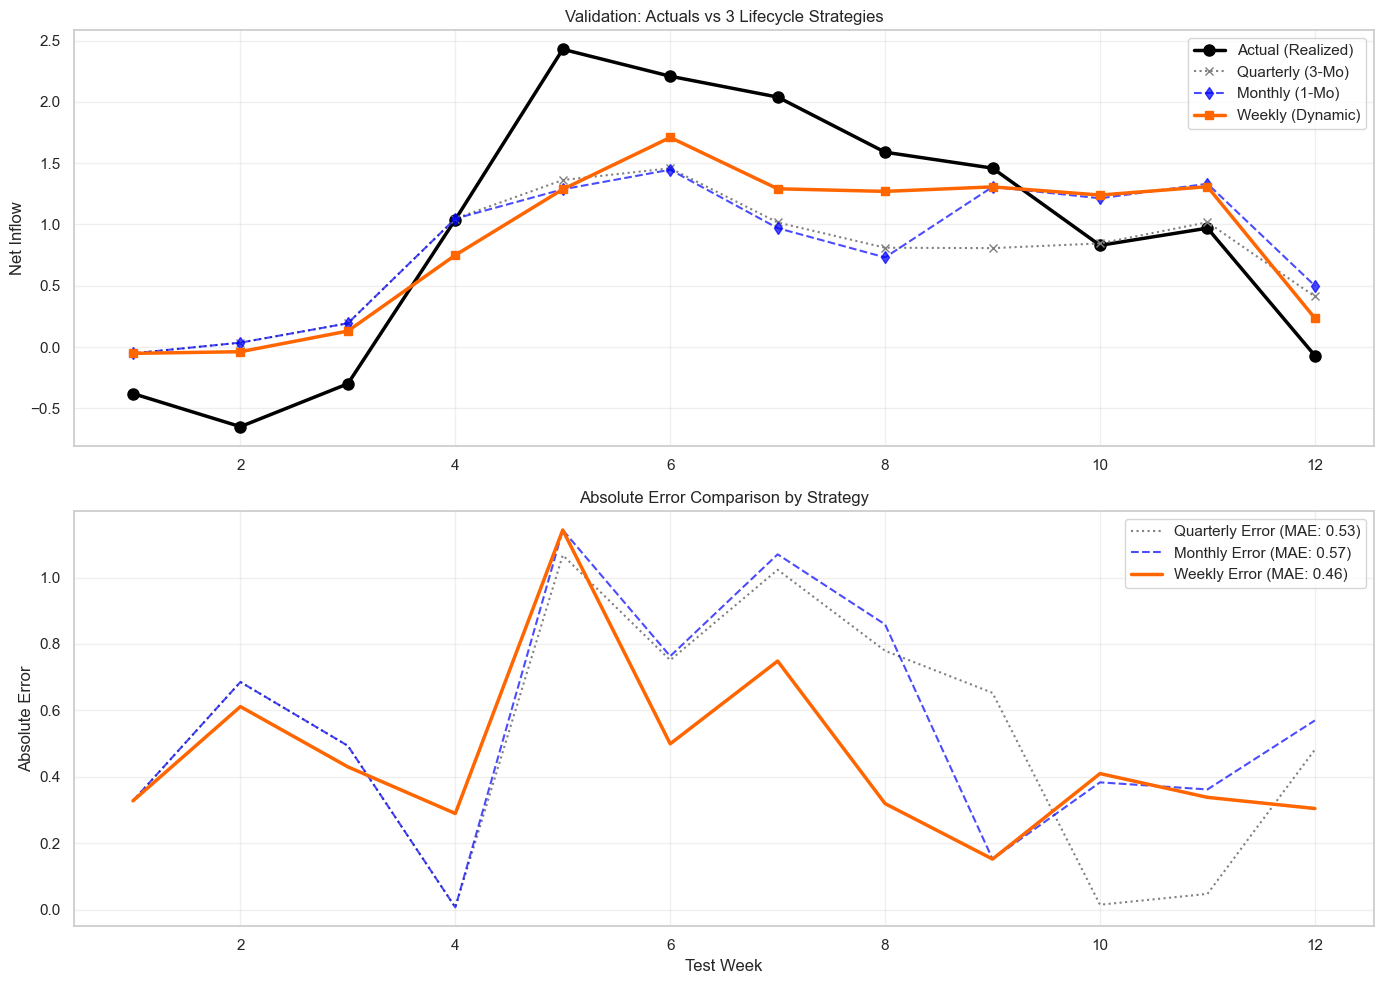

In [159]:
# Perform Lifecycle Validation (Static vs Dynamic)
# Using Updated Model features for this test
features_test = features_up  # Lag1 + Roll3
perform_lifecycle_validation(df, features_test, target='NET', test_weeks=12)
